In [1]:
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
file = open("testfile.txt","w") #creare file txt per scrivere "w"

file.write("""
C1 + Cn -> Cx
Cx -> C1 +Cn


""")

#file.write(" A -> D \n")
file.close() #chiudere il file

In [3]:
reactionCount = 0
G = nx.DiGraph()
reactions = set()
reaction_dict = dict()

# read the input file
for line in open("testfile.txt", "r"):
    line = line.replace(" ", "").strip()
    if len(line) == 0:
        continue
    left, right = line.split("->") #scandisce il testo word by word
    reactionCount += 1

    left = left.split("+")
    #left = map((lambda x: x.strip()), left)
    right = right.split("+")
    #right = map((lambda x: x.strip()), right)

    reaction_name = "R{}".format(reactionCount)

    # add the reaction into the graph
    assert not G.has_node(reaction_name)
    reactions.add(reaction_name)
    reaction_dict[reaction_name] = tuple(sorted(right))  # IMPORTANT: sorted is used to avoid ambiguity and tuple is for comparison
    G.add_node(reaction_name)

    # add the nodes on the LEFT of the reaction and a link between them and the reaction itself
    for node_name in left:
        if not G.has_node(node_name):
            G.add_node(node_name)
        G.add_edge(node_name, reaction_name, r="+")

    # add the nodes on the RIGHT of the reaction and a link between the reaction and them
    for node_name in right:
        if not G.has_node(node_name):
            G.add_node(node_name)
        G.add_edge(reaction_name, node_name, r="+")

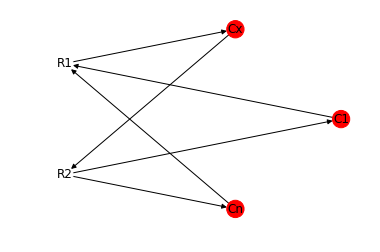

In [4]:
pos = nx.circular_layout(G, scale= 20)
shape=[]
color_map = ["w" if (node in reactions) else "r" for node in G.nodes()]
edge_map = ["k" if (G.get_edge_data(u,v)["r"] == "+") else "r" for u,v in G.edges()]

nx.draw_networkx(G, pos, node_color=color_map, edge_color=edge_map, node_shape='o', arrows=True)
limits=plt.axis('off') # turn off axis
plt.show()

In [5]:
edge_set = set(tuple(edge) for edge in G.edges())
in_edges = collections.defaultdict(list)
out_edges = collections.defaultdict(list)
for b,e in edge_set:
    in_edges[e].append(b)
    out_edges[b].append(e)
print in_edges

# precompute the reactions with the same right side
equal_reactions = dict(
    (min((r1,r2), (r2,r1)), reaction_dict[r1] == reaction_dict[r2])
    for r1 in reactions
    for r2 in reactions
    if r2 > r1
)

siblings_and_reaction = set(
    min((s1,s2,reaction), (s2,s1,reaction))  # this is to avoid duplicates in which the order of the tuple changes
    for reaction, species in in_edges.iteritems()
    if reaction.startswith("R")  # this is to ensure that the first term is a reaction
    for s1 in species
    for s2 in species
    if s1!=s2
)
print siblings_and_reaction

conflicts = set(
    (s2, r2)
    for s1, s2, r1 in siblings_and_reaction
    for r2 in out_edges[s1]
    if r1 != r2 and not equal_reactions[min((r1,r2), (r2,r1))]
) - edge_set
print conflicts

defaultdict(<type 'list'>, {'C1': ['R2'], 'Cx': ['R1'], 'R1': ['Cn', 'C1'], 'R2': ['Cx'], 'Cn': ['R2']})
set([('C1', 'Cn', 'R1')])
set([])


In [6]:
for u,v in conflicts:
    G.add_edge(u, v, r='-')

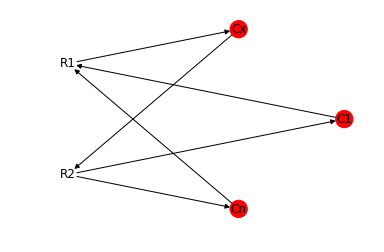

In [7]:
pos= nx.circular_layout(G, scale= 1)
color_map = ["w" if (node in reactions) else "r" for node in G.nodes()]
edge_map = ["k" if (G.get_edge_data(u,v)["r"] == "+") else "r" for u,v in G.edges()]

nx.draw_networkx(G, pos, node_color=color_map, edge_color=edge_map, node_shape='o', arrows=True)  
limits=plt.axis('off') # turn off axis
plt.show()

In [8]:
def get_path_r(G, u, v):
    assert G.has_node(u) and G.has_node(v)

    queue = collections.deque([v])
    edge_set = set(tuple(edge) for edge in G.edges())
    in_edges = collections.defaultdict(list)
    out_edges = collections.defaultdict(list)
    for b,e in edge_set:
        in_edges[e].append(b)
        out_edges[b].append(e)

    node_colors = dict()
    while len(queue):
        out_node = queue.pop()
        out_node_color = node_colors.get(out_node, None)

        for in_node in in_edges[out_node]:
            # rule to propagate the colors
            edge_r = G.get_edge_data(in_node, out_node)["r"]
            if out_node_color is not None:
                if out_node_color == "?":
                    color_propagation = "?"
                elif edge_r == "-" and out_node_color == "-":
                    color_propagation = "+"
                elif edge_r == "-" and out_node_color == "+":
                    color_propagation = "-"
                elif edge_r == "+" and out_node_color == "-":
                    color_propagation = "-"
                elif edge_r == "+" and out_node_color == "+":
                    color_propagation = "+"
            else:
                color_propagation = edge_r

            # propagation of the color
            in_node_color = node_colors.get(in_node, None)
            if in_node_color is None:
                node_colors[in_node] = color_propagation
                if color_propagation == "?":
                    queue.appendleft(in_node)
                else:
                    queue.append(in_node)
            elif in_node_color != color_propagation and in_node_color != "?":
                node_colors[in_node] = "?"
                queue.appendleft(in_node)
    return node_colors.get(u, None)

In [19]:
print get_path_r(G, "C1", "Cx")

+


# TEST

In [23]:
Gtest = nx.DiGraph()

Gtest.add_node("A")
Gtest.add_node("B")
Gtest.add_node("C")
Gtest.add_node("D")
Gtest.add_node("E")

Gtest.add_edge("A", "B", r="-")
Gtest.add_edge("B", "C", r="+")
Gtest.add_edge("C", "B", r="+")
Gtest.add_edge("C", "D", r="+")
Gtest.add_edge("D", "E", r="+")

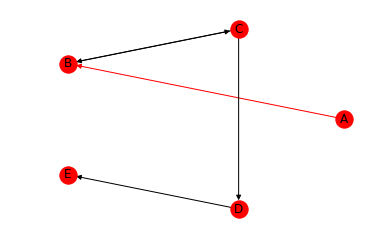

In [24]:
pos = nx.circular_layout(Gtest, scale= 1)
edge_map = ["k" if (Gtest.get_edge_data(u,v)["r"] == "+") else "r" for u,v in Gtest.edges()]

nx.draw_networkx(Gtest, pos, node_color="r", edge_color=edge_map, node_shape='o', arrows=True)  
limits=plt.axis('off') # turn off axis
plt.show()

In [25]:
print get_path_r(Gtest, "C", "D")

+
